In the project, given a consumer complaint narrative, the model attempts to predict which product the complaint is about. This is a multi-class text classification problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import chart_studio.plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

/Users/universebright/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Dataset is from here: https://catalog.data.gov/dataset/consumer-complaint-database
<br>
Similar one can be found on Kaggle: https://www.kaggle.com/cfpb/us-consumer-finance-complaints

In [2]:
df = pd.read_csv('complaints.csv')

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-03-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,330XX,NaN,Other,Web,2020-03-18,Closed with explanation,Yes,NaN,3571115
1,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
3,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
4,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198


In [4]:
df = df[['Product', 'Consumer complaint narrative']]

In [5]:
df.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Debt collection,transworld systems inc. \nis trying to collect...
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
4,Debt collection,"Over the past 2 weeks, I have been receiving e..."


In [6]:
df.dropna(inplace=True)

In [7]:
df = df.reset_index()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507523 entries, 0 to 507522
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   index                         507523 non-null  int64 
 1   Product                       507523 non-null  object
 2   Consumer complaint narrative  507523 non-null  object
dtypes: int64(1), object(2)
memory usage: 11.6+ MB


In [9]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    152991
Debt collection                                                                 109568
Mortgage                                                                         62670
Credit card or prepaid card                                                      33730
Credit reporting                                                                 31588
Student loan                                                                     25456
Checking or savings account                                                      19971
Credit card                                                                      18838
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             8509
Money transfer, virtual currency, or money 

## Label Consolidation
After first glance of the labels, we realized that there are things we can do to make our lives easier.
* Consolidate “Credit reporting” into “Credit reporting, credit repair services, or other personal consumer reports”.
* Consolidate “Credit card” into “Credit card or prepaid card”.
* Consolidate “Payday loan” into “Payday loan, title loan, or personal loan”.
* Consolidate “Virtual currency” into “Money transfer, virtual currency, or money service”.
* “Other financial service” has very few number of complaints and it does not mean anything, so, I decide to remove it.

In [10]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [11]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

After consolidation, we have 13 labels.

## Text Pre-processing

First, have a look how dirty the texts are.

In [12]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [13]:
print_plot(10)

MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX XXXX XXXX XXXX SC XXXX My DOB XXXX my SS XXXX. I have addresses on my file that are not mine please remove the following addresses : XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, NY XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX XXXX , XXXX, OH XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, OH XXXX XXXX XXXX  XXXX XXXX XXXX XXXX, XXXX, NJ XXXX. 
I have attach my proof of ID and address.
Product: Credit reporting, credit repair services, or other personal consumer reports


In [14]:
print_plot(1000)

Please be advised that I have attempted to resolve this matter with Synchrony Bank, but the Synchrony has been non-responsive and completely ignored any attempts at providing good customer service. I am upset that Synchrony Bank took extreme measures to ruin my credit, including not contacting me regarding the one late payment that I had on my account. 
Currently, my credit report is reflecting one 30-day delinquency for XX/XX/XXXX and one 60-day delinquency for XXXX of XXXX on this account. I am not disputing the late payment in itself, but I am very upset that Synchrony would not take the time to understand my circumstances and assist me with this matter. 
I opened a XXXX  XXXX  XXXX XXXX card in XX/XX/XXXX. I consistently made my minimum payments each month. In XX/XX/XXXX, Synchrony urged me to enroll in paperless billing and I did. I have consistently had both a monthly {$5.00} recurring charge and corresponding {$5.00} auto-draft payment take place on the account with minimal usag

It can been seen the text is pretty dirty.
<br>
Text preprocessing will include the following steps:
* Convert all text to lower case.
* Replace REPLACE_BY_SPACE_RE symbols by space in text.
* Remove symbols that are in BAD_SYMBOLS_RE from text.
* Remove “x” in text.
* Remove stop words.
* Remove digits in text.

In [15]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [16]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

Now go back to check the quality of our text pre-processing.

In [17]:
print_plot(10)

name live sc dob ss addresses file mine please remove following addresses oh oh oh ny oh oh oh oh oh nj attach proof id address
Product: Credit reporting, credit repair services, or other personal consumer reports


In [18]:
print_plot(1000)

please advised attempted resolve matter synchrony bank synchrony nonresponsive completely ignored attempts providing good customer service upset synchrony bank took etreme measures ruin credit including contacting regarding one late payment account currently credit report reflecting one day delinquency one day delinquency account disputing late payment upset synchrony would take time understand circumstances assist matter opened card consistently made minimum payments month synchrony urged enroll paperless billing consistently monthly  recurring charge corresponding  autodraft payment take place account minimal usage otherwise made  purchase forgot charged account increase automatic payment cover purchase synchrony assessed multiple late payments caused  purchase grow  balance checked credit report realized account delinquent synchrony bank contact information file address phone email never contacted regarding past due balance according synchrony representative spoke continuing make  a

Nice. Done text pre-processing.

## LSTM Modeling
* Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
* Limit the data set to the top 5,0000 words.
* Set the max number of words in each complaint at 250.

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 168750 unique tokens.


* Truncate and pad the input sequences so that they are all in the same length for modeling.

In [20]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (507231, 250)


* Converting categorical labels to numbers.

In [21]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (507231, 13)


* Train test split.

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(456507, 250) (456507, 13)
(50724, 250) (50724, 13)


* The first layer is the embedded layer that uses 100 length vectors to represent each word.
* SpatialDropout1D performs variational dropout in NLP models.
* The next layer is the LSTM layer with 100 memory units.
* The output layer must create 13 output values, one for each class.
* Activation function is softmax for multi-class classification.
* Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [23]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/universebright/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 410856 samples, validate on 45651 samples
Epoch 1/5
410856/410856 [==============================] - 4151s 10ms/step - loss: 0.7953 - accuracy: 0.7471 - val_loss: 0.5717 - val_accuracy: 0.8043
Epoch 2/5
410856/410856 [==============================] - 4165s 10ms/step - loss: 0.5387 - accuracy: 0.8146 - val_loss: 0.5146 - val_accuracy: 0.8213
Epoch 3/5
410856/410856 [==============================] - 3681s 9ms/step - loss: 0.4780 - accuracy: 0.8351 - val_loss: 0.4930 - val_accuracy: 0.8298
Epoch 4/5
410856/410856 [==============================] - 3634s 9ms/step - loss: 0.4352 - accuracy: 0.8506 - val_loss: 0.4859 - val_accuracy: 0.8330
Epoch 5/5
410856/410856 [==============================] - 3619s 9ms/step - loss: 0.4018 - accuracy: 0.8619 - val_loss: 0.4952 - val_accuracy: 0.8328


In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

50724/50724 [==============================] - 103s 2ms/step
Test set
  Loss: 0.500
  Accuracy: 0.833


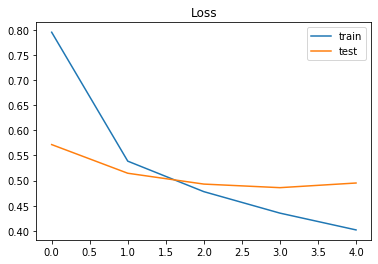

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

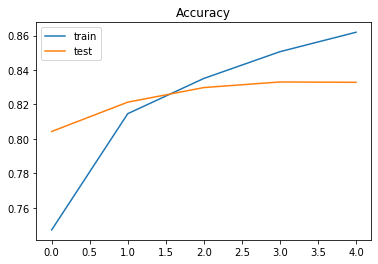

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Test with a New Complaint

In [31]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.5371246e-03 1.4365689e-03 9.1096730e-04 5.3953552e-01 2.3420390e-01
  2.2151734e-01 8.5816871e-05 2.7026988e-06 1.4225417e-04 4.0912331e-04
  1.3092219e-05 2.3833894e-05 1.8178455e-04]] Credit card or prepaid card
